<a href="https://colab.research.google.com/github/mirovix/CV_final_project/blob/main/NN_boats_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import the necessary packages
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import img_to_array
from imutils.object_detection import non_max_suppression
import numpy as np
import argparse
import cv2
from google.colab.patches import cv2_imshow
from google.colab import drive
from google.colab import files
import json
import io
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


np.random.seed(42)

In [3]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [4]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['accuracy'])
  plt.plot(history.epoch,history.history['val_accuracy'])
  plt.title('accuracy')

In [27]:
def non_max_suppression_slow(boxes, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
	# initialize the list of picked indexes
	pick = []
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
  # keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list, add the index
		# value to the list of picked indexes, then initialize
		# the suppression list (i.e. indexes that will be deleted)
		# using the last index
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
		suppress = [last]
    		# loop over all indexes in the indexes list
		for pos in xrange(0, last):
			# grab the current index
			j = idxs[pos]
			# find the largest (x, y) coordinates for the start of
			# the bounding box and the smallest (x, y) coordinates
			# for the end of the bounding box
			xx1 = max(x1[i], x1[j])
			yy1 = max(y1[i], y1[j])
			xx2 = min(x2[i], x2[j])
			yy2 = min(y2[i], y2[j])
			# compute the width and height of the bounding box
			w = max(0, xx2 - xx1 + 1)
			h = max(0, yy2 - yy1 + 1)
			# compute the ratio of overlap between the computed
			# bounding box and the bounding box in the area list
			overlap = float(w * h) / area[j]
			# if there is sufficient overlap, suppress the
			# current bounding box
			if overlap > overlapThresh:
				suppress.append(pos)
		# delete all indexes from the index list that are in the
		# suppression list
		idxs = np.delete(idxs, suppress)
	# return only the bounding boxes that were picked
	return boxes[pick]

In [5]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
drive.mount('/content/drive')

with open('/content/drive/MyDrive/dataset_boats/label_multi.json') as json_file:
    json_file = json.load(json_file)

data,targets = [],[]
width = 80
height = 80
i=1
train_images=[]
train_labels=[]

for row in json_file:
  
  if(i==175):
    break
  if(i%20==0):
    print(i)
  i=i+1
  gtvalues=[]
  for col in row['Label']['objects']:
    if(len(row['Label']) != 0):
      x_start = int(col['bbox']['left'])
      y_start = int(col['bbox']['top'])
      x_end = int(col['bbox']['left'] + col['bbox']['width'])
      y_end = int(col['bbox']['top'] + col['bbox']['height'])
      gtvalues.append({"x1":x_start,"x2":x_end,"y1":y_start,"y2":y_end})

  image_path = "/content/drive/MyDrive/dataset_boats/train/" + row['External ID']
  cv_image = cv2.imread(image_path)

  ss.setBaseImage(cv_image)
  ss.switchToSelectiveSearchFast()
  ssresults = ss.process()
  imout = cv_image.copy()
  counter = 0
  falsecounter = 0
  flag = 0
  fflag = 0
  bflag = 0
  for e,result in enumerate(ssresults):
    if e < 2000 and flag == 0:
      for gtval in gtvalues:
        x, y, w, h = result
        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
        if counter < 25:
          if iou > 0.75:
            timage = imout[y:y+h,x:x+w]
            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
            train_images.append(resized)
            train_labels.append(1)
            counter += 1
        else :
          fflag =1
        if falsecounter <30:
          if iou < 0.3:
            timage = imout[y:y+h,x:x+w]
            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
            train_images.append(resized)
            train_labels.append(0)
            falsecounter += 1
        else :
          bflag = 1
      if fflag == 1 and bflag == 1:
        #print("inside")
        flag = 1

#print(gtvalues) 
print(len(train_images))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
20
40
60
80
100
120
140
160
7139


In [6]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

from keras.applications.vgg16 import VGG16
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

#Xception try
vggmodel = VGG16(weights='imagenet', include_top=True)

for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

X=vggmodel.layers[-2].output
predictions = Dense(2, activation="softmax")(X)
model_final = Model(inputs = vggmodel.input, outputs = predictions)
opt = Adam(lr=0.0001)
model_final.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=["accuracy"])
model_final.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)

In [8]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

In [9]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 20, epochs= 30, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
20/20 [==============================] - 58s 432ms/step - loss: 0.5382 - accuracy: 0.8637 - val_loss: 0.0923 - val_accuracy: 0.9688

Epoch 00001: val_loss improved from inf to 0.09235, saving model to ieeercnn_vgg16_1.h5
Epoch 2/30
20/20 [==============================] - 8s 387ms/step - loss: 0.0860 - accuracy: 0.9757 - val_loss: 0.0891 - val_accuracy: 0.9844

Epoch 00002: val_loss improved from 0.09235 to 0.08911, saving model to ieeercnn_vgg16_1.h5
Epoch 3/30
20/20 [==============================] - 13s 636ms/step - loss: 0.1146 - accuracy: 0.9657 - val_loss: 0.0909 - val_accuracy: 0.9844

Epoch 00003: val_loss did not improve from 0.08911
Epoch 4/30
20/20 [==============================] - 8s 386ms/step - loss: 0.1031 - accuracy: 0.9652 - val_loss: 0.2574 - val_accuracy: 0.9688

Epoch 00004: val_loss did not improve from 0.08911
Epoch 5/30
20/20 [==============================] - 8s 393ms/step - loss: 0.1125 - accuracy: 0.9761 - val_loss: 0.0713 - val_accuracy: 0.9844

E

23/23 - 6s - loss: 0.0815 - accuracy: 0.9902
 accuracy: 99.02%


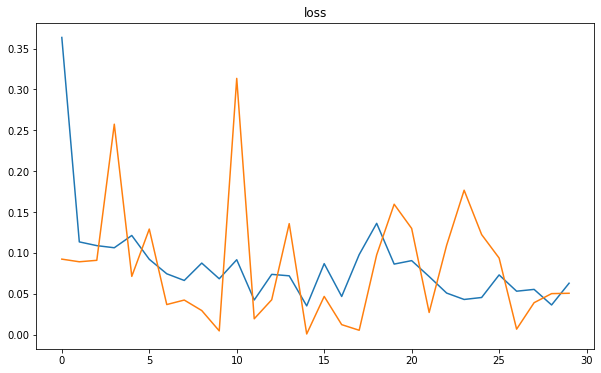

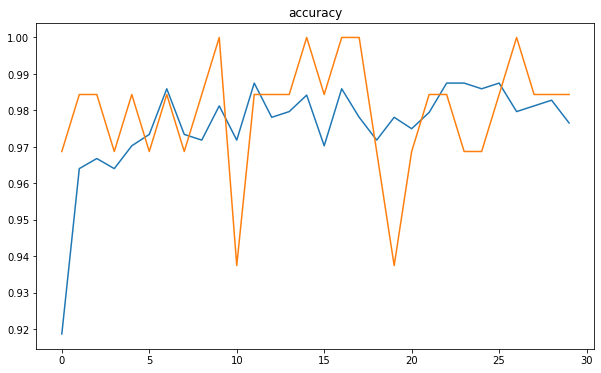

In [10]:
plot_loss(hist)
plot_accuracy(hist)

scores = model_final.evaluate(X_test, y_test, verbose=2)
print(" %s: %.2f%%" % (model_final.metrics_names[1], scores[1]*100))

0
250
500
750
1000
1250
1500
1750
2000


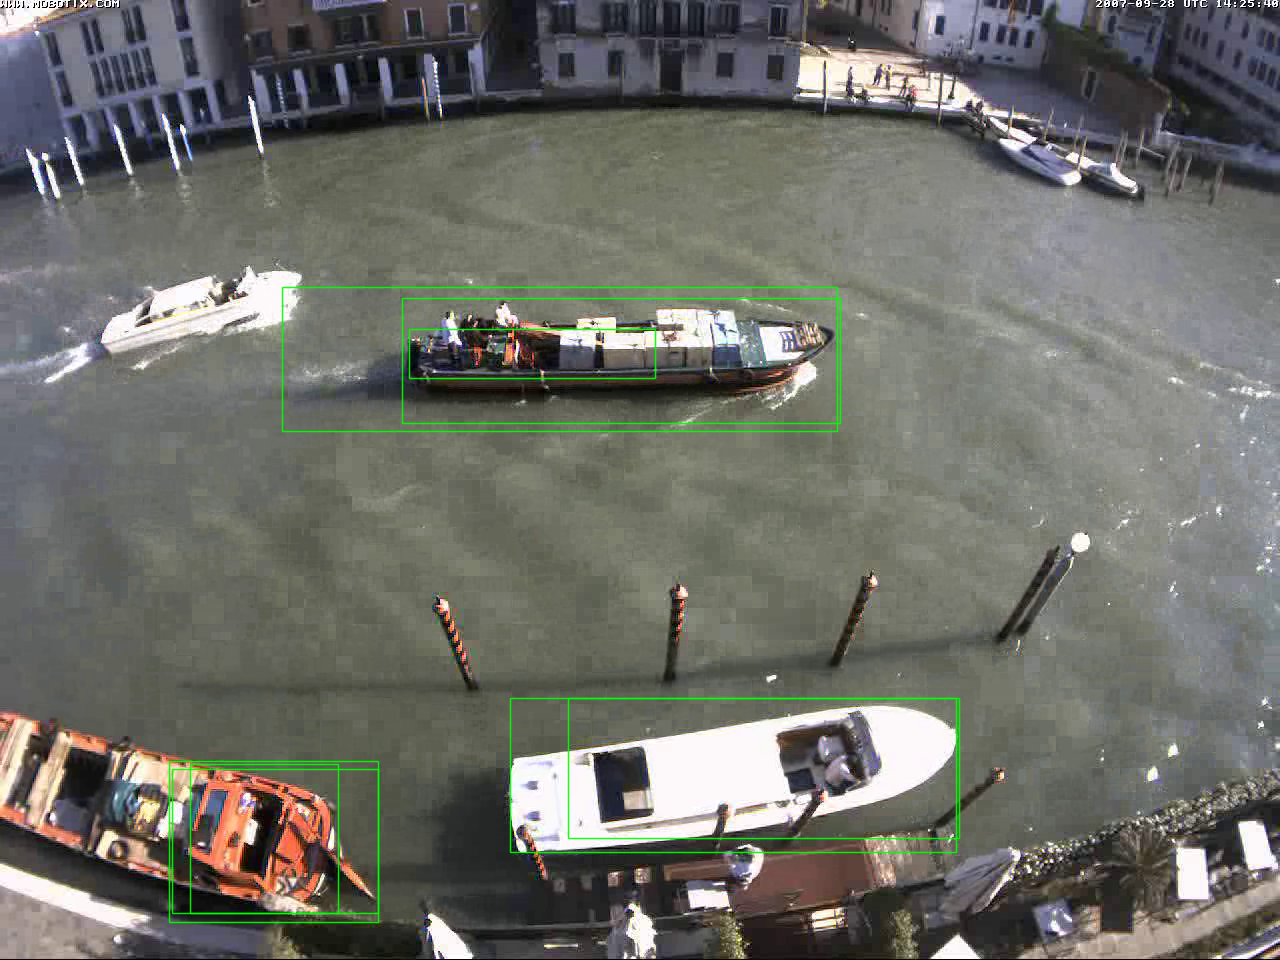

In [38]:
image_path = "/content/drive/MyDrive/dataset_boats/train/20130412_150512_31795.jpg" #20130412_151959_34446 #"/content/drive/MyDrive/dataset_boats/venice_dataset/07.png" 
image_path = "/content/drive/MyDrive/dataset_boats/venice_dataset/04.png"
img = cv2.imread(image_path)
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()
imout = img.copy()
boundingBoxes = []
for i,result in enumerate(ssresults):
  if(i>2000):
    break
  if(i%250==0):
    print(i)
  x,y,w,h = result
  timage = imout[y:y+h,x:x+w]
  resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
  img = np.expand_dims(resized, axis=0)
  out= model_final.predict(img)
  if out[0][0] > 0.90:
    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
 
#pick = non_max_suppression_slow(boundingBoxes, 0.3)
#for (x, y, x_2, y_3) in pick:
#   cv2.rectangle(imout, (x, y), (x_2, y_3), (0, 255, 0), 1, cv2.LINE_AA)

cv2_imshow(imout)